# Airbnb Pricing Algorithm

The scope of this project is to create a deep learning algorithm to predict the price of an Airbnb listing.

This file categorizes the price of a listing.

---

> Anna Makropoulou(P2822123)
> 
> Anastasios Safras(P2822130)
> 
> Anastasios Moraitis(P2822124)
> 
> Ioannis Dekoulakos(P2822110)
> 
> Athens University of Economics and Business <br />
> Machine Learning and Content Analytics - PT- PT <br />
 

In [1]:
import pandas as pd
import sys
from utils import Constants
from sklearn.model_selection import train_test_split
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from tensorflow import keras

from collections import Counter

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import json
import pydot

Functions to pre-process the text data.

In [2]:
from utils import remove_emoji, remove_url, clean_text, clean_text2

In [3]:
constants = Constants()

Preprocessing the listing data files and import them.

In [4]:
# Preprocessing and import of data.
from utils import transform_and_import_data
listings_3 = transform_and_import_data(constants.DATA_PATH)

In [5]:
# removing unnecessary columns.
listings_3.set_index("id", inplace=True)

In [6]:
# Creating the datarame.
df = pd.DataFrame(listings_3, columns= ['name', 'description', 'price'])

In [11]:
# Looking at the texts.
df.head()

,name,description,price
id,,,
10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",Athens Furnished Apartment No6 is 3-bedroom ap...,103
10990,Athens Quality Apartments - Deluxe Apartment,Athens Quality Apartments - Deluxe apartment i...,71
10993,Athens Quality Apartments - Studio,The Studio is an <br />-excellent located <br ...,55
2219385,Modern central flat Old Olympic stadium-Acropolis,"Located in the heart of Athens, few minutes wa...",65
10995,"AQA-No2 1-bedroom, smart tv, fiber connection,","AQA No2 is 1-bedroom apartment (47m2), on the ...",75


In [7]:
# Creating price fixed points for range.
df["price"][(df["price"] > 0) & (df["price"]<=df.price.quantile(q=0.33))] = 33
df["price"][(df["price"] > 49) & (df["price"]<=df.price.quantile(q=0.66))] = 66
df["price"][df["price"] > df.price.quantile(q=0.66)] = 100

In [8]:
# Creating categories, If the predicted price from the main model differs from the category that is suppose be
# then there will be a reduction or an increase in price. 
df["price"][df["price"] == 33] = 'cheap'
df["price"][df["price"] == 66] = 'average'
df["price"][df["price"] == 100] = 'expensive'
df.price.describe()

count       11321
unique          3
top       average
freq         3800
Name: price, dtype: object

In [9]:
# Combine text from all  columns.
df['alltext'] = df['name'] + df['description']
print(len(df))
df

11321


,name,description,price,alltext
id,,,,
10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",Athens Furnished Apartment No6 is 3-bedroom ap...,expensive,"96m2, 3BR, 2BA, Metro, WI-FI etc...Athens Furn..."
10990,Athens Quality Apartments - Deluxe Apartment,Athens Quality Apartments - Deluxe apartment i...,average,Athens Quality Apartments - Deluxe ApartmentAt...
10993,Athens Quality Apartments - Studio,The Studio is an <br />-excellent located <br ...,average,Athens Quality Apartments - StudioThe Studio i...
2219385,Modern central flat Old Olympic stadium-Acropolis,"Located in the heart of Athens, few minutes wa...",average,Modern central flat Old Olympic stadium-Acropo...
10995,"AQA-No2 1-bedroom, smart tv, fiber connection,","AQA No2 is 1-bedroom apartment (47m2), on the ...",average,"AQA-No2 1-bedroom, smart tv, fiber connection,..."
...,...,...,...,...
646258081308550485,"Όμορφο διαμέρισμα ρετιρέ 5ου ορόφου, στου Zogr...","Όμορφο ρετιρέ διαμέρισμα του 5ου ορόφου, 48 τε...",cheap,"Όμορφο διαμέρισμα ρετιρέ 5ου ορόφου, στου Zogr..."
48973284,100mbps @ Kyprou Square,EXCELLENT LOCATION !!!<br />3rd floor apartmen...,cheap,100mbps @ Kyprou SquareEXCELLENT LOCATION !!!<...
24539337,Quiet renovated lovely appartment2,Το μόνο που χρειάζεστε είναι η ζεστασιά και η ...,cheap,Quiet renovated lovely appartment2Το μόνο που ...


Split train/test with ration 10:1

In [10]:
# TEST ALLTEXT WITH CATEGORICAL SCORE
X = df.drop(columns=(['name','description']), axis=1)
y = df['price']

# split the data into train and test set
X_train, X_test, not_used, not_used = train_test_split(X, y, test_size=0.1, random_state=24)

print(len(X_train))
print(len(X_test))

10188
1133


In [17]:
X_train

,price,alltext
id,,
43308352,average,Athens City Apartment next to Intercontinental...
31662488,average,Adorable flat for 4 ppl in KolonakiWelcome to ...
30638600,cheap,Retro ElegantBeautiful fully renovated house ...
17277394,cheap,Gazi area 4 minutes to Kerameikos Subway Stati...
42709112,average,"The 'BLU' apartment, central, next to metroIn ..."
...,...,...
36576653,expensive,Deluxe 4persons room number 3- Still Athens ho...
38818513,average,Athens house next to the metro stationCosy hom...
28201586,average,"Anna's Home, AthensNewly renovated apartment, ..."


Let us pre-process the data

In [11]:
# Importing train text data and applying the cleaning.
train_data= X_train
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['alltext'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['price'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['alltext'] = train_data['alltext'].apply(remove_emoji)
train_data['alltext'] = train_data['alltext'].apply(remove_url)
train_data['alltext'] = train_data['alltext'].apply(clean_text)
train_data['alltext'] = train_data['alltext'].apply(clean_text2)

# Importing train text data and applying the cleaning.
test_data= X_test
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['alltext'].apply(lambda x:len(str(x).split())) 
max_test_sentence_length  = test_data['Num_words_text'].max()
mask = test_data['Num_words_text'] >2
test_data = test_data[mask]
print('-------Test data--------')
print(test_data['price'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['alltext'] = test_data['alltext'].apply(remove_emoji)
test_data['alltext'] = test_data['alltext'].apply(remove_url)
test_data['alltext'] = test_data['alltext'].apply(clean_text)
test_data['alltext'] = test_data['alltext'].apply(clean_text2)

print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Train data--------
average      3382
cheap        3367
expensive    3355
Name: price, dtype: int64
10104
-------------------------
-------Test data--------
average      396
cheap        372
expensive    357
Name: price, dtype: int64
1125
-------------------------
Train Max Sentence Length :201
Test Max Sentence Length :190


Tokenizer

In [12]:
# Creating tokenizer for our model
num_words = 500

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['alltext'].tolist())
# Print out a test text.
print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 1, 21, 9]]


Splitting text data.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['alltext'].tolist(),\
                                                      train_data['price'].tolist(),\
                                                      test_size=0.2,\
                                                      random_state=0)

# Print the ration of the split data.
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

# Pass the texts through the tokenizer.
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['alltext'].tolist()) )

x_train = pad_sequences(x_train, padding='post', maxlen=210)
x_valid = pad_sequences(x_valid, padding='post', maxlen=210)
x_test = pad_sequences(x_test, padding='post', maxlen=210)

print("------x_train[0]------")
print(x_train[0].reshape((1, 14, 15)))

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

print("-----train_labels-----")
print(train_labels)

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['price'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:8083
Class distributionCounter({'average': 2722, 'expensive': 2693, 'cheap': 2668})
Valid data len:2021
Class distributionCounter({'cheap': 699, 'expensive': 662, 'average': 660})
------x_train[0]------
[[[  2 176   2   1 130 174   1 468 450   9  21 191  29   1 148]
  [176   7 416   1  66   1  20   2   1  30   2  60   4   1  66]
  [  1  63 130 425  22   1   2   1   1   2  12   8   2 137  53]
  [  2 411  11  10 119   1   1 291  72   1   1   1   1 348  85]
  [  1   1   1   3   4   1   1   1   1   1 178 129  18   1   4]
  [289  52 365   1 227   1   3   1   4   1   1   1   1   3   1]
  [ 21   1   1   7 489  22 314   1   2  37  23   1 115 393 328]
  [  2 130 128   1 111  53   2  35   6 298   2 115 128   1   1]
  [  1   9   2   1   1 369   2   1 104  99 107   1 302   1   1]
  [ 14   1  21   0   0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0

In [14]:
# USE FOR THE REPORT
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['expensive', 'average', 'expensive', 'expensive', 'expensive', 'average', 'cheap', 'cheap', 'cheap', 'average']
Text to number
[2 0 2 2 2 0 1 1 1 0]
Number to category
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [15]:
# USE FOR THE REPORT
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

======Train dataset ====
tf.Tensor(
[  2 176   2   1 130 174   1 468 450   9  21 191  29   1 148 176   7 416
   1  66   1  20   2   1  30   2  60   4   1  66   1  63 130 425  22   1
   2   1   1   2  12   8   2 137  53   2 411  11  10 119   1   1 291  72
   1   1   1   1 348  85   1   1   1   3   4   1   1   1   1   1 178 129
  18   1   4 289  52 365   1 227   1   3   1   4   1   1   1   1   3   1
  21   1   1   7 489  22 314   1   2  37  23   1 115 393 328   2 130 128
   1 111  53   2  35   6 298   2 115 128   1   1   1   9   2   1   1 369
   2   1 104  99 107   1 302   1   1  14   1  21   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(210,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  5  88   1   1 333   

Creating a simple Convolutional Neural Network model  

In [16]:
# Selecting number of features.
max_features =500
# Selecting size of the embedding dimensions.
embedding_dim =64
# Selecting the maximum sequence length of our text.
sequence_length = 210

# Creating the sequensial model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

# Creating the convolution layer.
model.add(tf.keras.layers.Conv1D(64,2, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               

# Overfitting protections
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               
# Display model's summary.
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 210, 64)           32064     
                                                                 
 conv1d (Conv1D)             (None, 209, 64)           8256      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 40,515
Trainable params: 40,515
Non-trainable params: 0
____________________________________________________

Train our model

In [17]:
# Train it for 20 epochs.
epochs = 20

# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(100).batch(256),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(256),
                    verbose=1)

Epoch 1/20
32/32 [==============================] - 3s 52ms/step - loss: 1.1411 - categorical_accuracy: 0.3641 - val_loss: 1.1249 - val_categorical_accuracy: 0.4354
Epoch 2/20
32/32 [==============================] - 2s 48ms/step - loss: 1.1137 - categorical_accuracy: 0.4325 - val_loss: 1.0926 - val_categorical_accuracy: 0.5027
Epoch 3/20
32/32 [==============================] - 2s 48ms/step - loss: 1.0773 - categorical_accuracy: 0.4805 - val_loss: 1.0468 - val_categorical_accuracy: 0.5354
Epoch 4/20
32/32 [==============================] - 2s 49ms/step - loss: 1.0403 - categorical_accuracy: 0.5023 - val_loss: 1.0081 - val_categorical_accuracy: 0.5443
Epoch 5/20
32/32 [==============================] - 2s 49ms/step - loss: 1.0162 - categorical_accuracy: 0.5192 - val_loss: 0.9895 - val_categorical_accuracy: 0.5463
Epoch 6/20
32/32 [==============================] - 2s 48ms/step - loss: 1.0001 - categorical_accuracy: 0.5352 - val_loss: 0.9781 - val_categorical_accuracy: 0.5438
Epoch 7/20

Checking for overfitting.

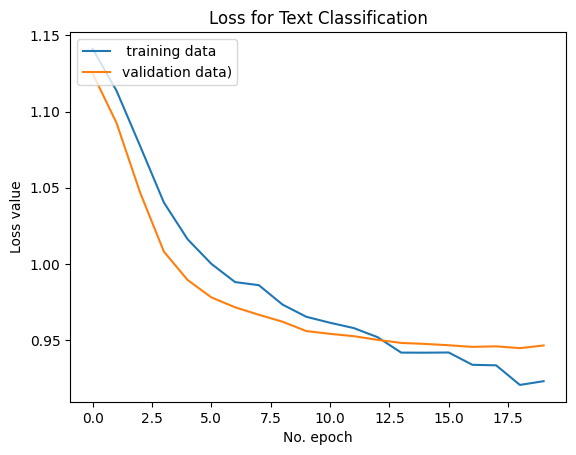

In [18]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Save our model and tokenizer.

In [19]:
# Saving the model and tokenizer
model.save('C:\maching_learning_data\\savedTFCNNModel\\tf_cnnmodel') 
json_string = tokenizer.to_json()

with open('C:\maching_learning_data\\savedTFCNNModel\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

INFO:tensorflow:Assets written to: C:\maching_learning_data\savedTFCNNModel\tf_cnnmodel\assets


INFO:tensorflow:Assets written to: C:\maching_learning_data\savedTFCNNModel\tf_cnnmodel\assets


Lets load our model and test on test data

In [20]:
# Loading the saved model and display a summary.
new_model = tf.keras.models.load_model('C:\maching_learning_data\\savedTFCNNModel\\tf_cnnmodel')
new_model.summary()

# Loading the saved tokenizer.
with open('C:\maching_learning_data\\savedTFCNNModel\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 210, 64)           32064     
                                                                 
 conv1d (Conv1D)             (None, 209, 64)           8256      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 40,515
Trainable params: 40,515
Non-trainable params: 0
____________________________________________________

In [21]:
# Use test data through the tokenizer.
x_test  = np.array( tokenizer1.texts_to_sequences(test_data['alltext'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=210)

In [22]:

# Run model.
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
#print(predictions)
predict_results = predictions.argmax(axis=1)

test_data['cost']= predict_results
test_data['cost'] = np.where((test_data.cost == 0),'average',test_data.cost)
test_data['cost'] = np.where((test_data.cost == '1'),'cheap',test_data.cost)
test_data['cost'] = np.where((test_data.cost == '2'),'expensive',test_data.cost)

labels = ['cheap', 'average','expensive']
    
print(classification_report(test_data['price'].tolist(),test_data['cost'].tolist(),labels=labels))

Generate predictions for all samples
36/36 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       cheap       0.56      0.62      0.59       372
     average       0.49      0.36      0.41       396
   expensive       0.60      0.70      0.65       357

    accuracy                           0.55      1125
   macro avg       0.55      0.56      0.55      1125
weighted avg       0.54      0.55      0.54      1125



In [23]:
test_data[1:10]

,price,alltext,Num_words_text,cost
id,,,,
31671716,average,katerinas feng shui home afor those who love h...,174,expensive
17599277,expensive,charming center bedroom apt metropresented exc...,147,cheap
31662450,expensive,grstath1033 president apartment wacropol viewe...,139,expensive
24484273,average,koukaki apartment with sunny balcony near the ...,52,cheap
641158163427645517,cheap,athens city center apartment with park viewa n...,38,cheap
19139322,cheap,acropolis cozy apartment netflix providedbeaut...,133,cheap
24942511,expensive,resort athens center kolonakii love traveling...,179,average
638161332234061438,expensive,downtown urban flat for people plakawelcome on...,169,expensive
26299996,average,maroulas house br bthe spacebbr metropolitan h...,142,cheap


LSTM Model

In [24]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 500
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 210
# This is fixed.
EMBEDDING_DIM = 64

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['alltext'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 30774 unique tokens.


In [25]:
# Change input sequences to have the same length for modeling.
X = tokenizer.texts_to_sequences(train_data['alltext'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10104, 210)


In [26]:
# Changing categorical labels the same as the first model.
Y = pd.get_dummies(train_data['price']).values
print(Y)
print('Shape of label tensor:', Y.shape)

[[1 0 0]
 [1 0 0]
 [0 1 0]
 ...
 [1 0 0]
 [0 0 1]
 [0 1 0]]
Shape of label tensor: (10104, 3)


In [27]:
# Split the data to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9093, 210) (9093, 3)
(1011, 210) (1011, 3)


Creating the LSTM model.

In [28]:

# Creating teh sequential model.
model2 = Sequential()
# Add the values for the Embedding Layer.
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# Add the variational dropout value.
model2.add(SpatialDropout1D(0.6))
# Add the LSTM layer with 64 memory units.
model2.add(LSTM(64, dropout=0.6, recurrent_dropout=0.6))
# Add an Activation function.
model2.add(Dense(3, activation='softmax'))
# Use categorical_crossentropy as a loss function
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 256

history2 = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Epoch 1/15
29/29 [==============================] - 23s 719ms/step - loss: 1.0953 - accuracy: 0.3552 - val_loss: 1.0860 - val_accuracy: 0.3771
Epoch 2/15
29/29 [==============================] - 21s 707ms/step - loss: 1.0739 - accuracy: 0.4091 - val_loss: 1.0416 - val_accuracy: 0.4557
Epoch 3/15
29/29 [==============================] - 20s 706ms/step - loss: 1.0213 - accuracy: 0.4707 - val_loss: 0.9761 - val_accuracy: 0.5256
Epoch 4/15
29/29 [==============================] - 20s 703ms/step - loss: 0.9803 - accuracy: 0.5030 - val_loss: 0.9453 - val_accuracy: 0.5355
Epoch 5/15
29/29 [==============================] - 21s 713ms/step - loss: 0.9583 - accuracy: 0.5228 - val_loss: 0.9437 - val_accuracy: 0.5426
Epoch 6/15
29/29 [==============================] - 21s 723ms/step - loss: 0.9481 - accuracy: 0.5249 - val_loss: 0.9280 - val_accuracy: 0.5542
Epoch 7/15
29/29 [==============================] - 21s 720ms/step - loss: 0.9355 - accuracy: 0.5367 - val_loss: 0.9065 - val_accuracy: 0.5668

In [29]:
# Saving the model and tokenizer
model2.save('C:\maching_learning_data\\savedLSTMModel\\LSTMmodel') 
json_string = tokenizer.to_json()

with open('C:\maching_learning_data\\savedLSTMModel\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

INFO:tensorflow:Assets written to: C:\maching_learning_data\savedLSTMModel\LSTMmodel\assets


INFO:tensorflow:Assets written to: C:\maching_learning_data\savedLSTMModel\LSTMmodel\assets


In [30]:
# Loading the saved model and display a summary.
new_model2 = tf.keras.models.load_model('C:\maching_learning_data\\savedLSTMModel\\LSTMmodel')
new_model2.summary()

# Loading the saved tokenizer.
with open('C:\maching_learning_data\\savedLSTMModel\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 64)           32000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 210, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 65,219
Trainable params: 65,219
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Evaluating model by checking the accuracy for the out test data.
accr = new_model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 1s 26ms/step - loss: 0.8703 - accuracy: 0.5945
Test set
  Loss: 0.870
  Accuracy: 0.594


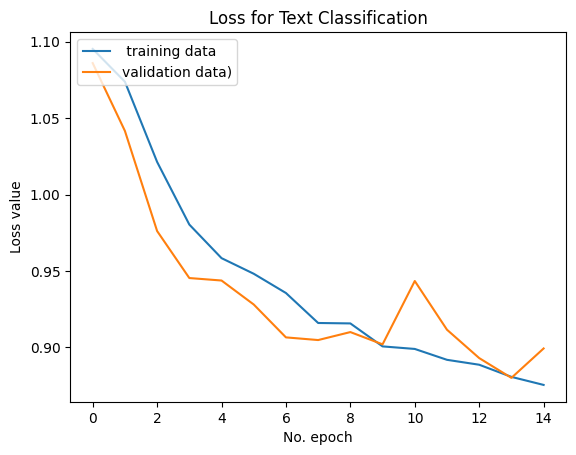

In [32]:
# Plot of the loss for trainning and calidation data to check for overfitting. 
plt.plot(history2.history['loss'], label=' training data')
plt.plot(history2.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

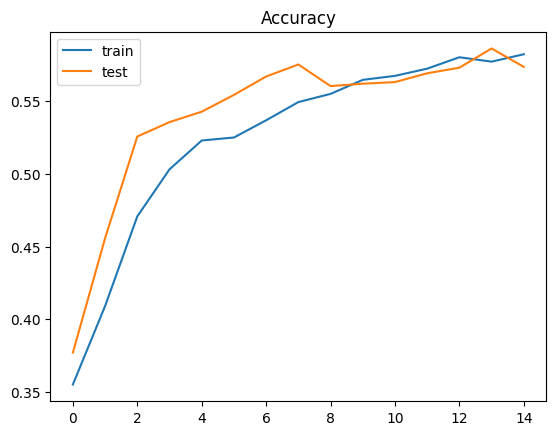

In [33]:
# Plot to check the difference in accuracy for train and test data.
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [34]:
# Run LSTM model.
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
seq  = np.array( tokenizer1.texts_to_sequences(test_data['alltext'].tolist()) )
padded = pad_sequences(seq, maxlen=210)
pred = new_model2.predict(padded)
labels = ['average, cheap, expensive']

predict_results = pred.argmax(axis=1)

test_data['cost']= predict_results
test_data['cost'] = np.where((test_data.cost == 0),'average',test_data.cost)
test_data['cost'] = np.where((test_data.cost == '1'),'cheap',test_data.cost)
test_data['cost'] = np.where((test_data.cost == '2'),'expensive',test_data.cost)
print(classification_report(test_data['price'].tolist(),test_data['cost'].tolist()))

36/36 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

     average       0.51      0.19      0.28       396
       cheap       0.54      0.76      0.63       372
   expensive       0.57      0.72      0.63       357

    accuracy                           0.55      1125
   macro avg       0.54      0.56      0.51      1125
weighted avg       0.54      0.55      0.51      1125



In [35]:
test_data[1:8]

,price,alltext,Num_words_text,cost
id,,,,
31671716,average,katerinas feng shui home afor those who love h...,174,average
17599277,expensive,charming center bedroom apt metropresented exc...,147,average
31662450,expensive,grstath1033 president apartment wacropol viewe...,139,expensive
24484273,average,koukaki apartment with sunny balcony near the ...,52,cheap
641158163427645517,cheap,athens city center apartment with park viewa n...,38,cheap
19139322,cheap,acropolis cozy apartment netflix providedbeaut...,133,cheap
24942511,expensive,resort athens center kolonakii love traveling...,179,expensive
